# Receptive Field and Gabor Fitting

We first load the data.

In [1]:
import sys
sys.path.append("../")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from jax.experimental.optimizers import adam

from src.spikeloader import SpikeLoader
from src.gabor_analysis.gabor_diag import GaborDiag
from src.gabor_analysis.gabor_fit import GaborFit
from src.receptive_field.rf import ReceptiveField

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set()
loader = SpikeLoader('../superstim.npz')

Loading data.


### Generate RFs for the first 50 principal components.

Running linear regression with ridge coefficient  1.10.


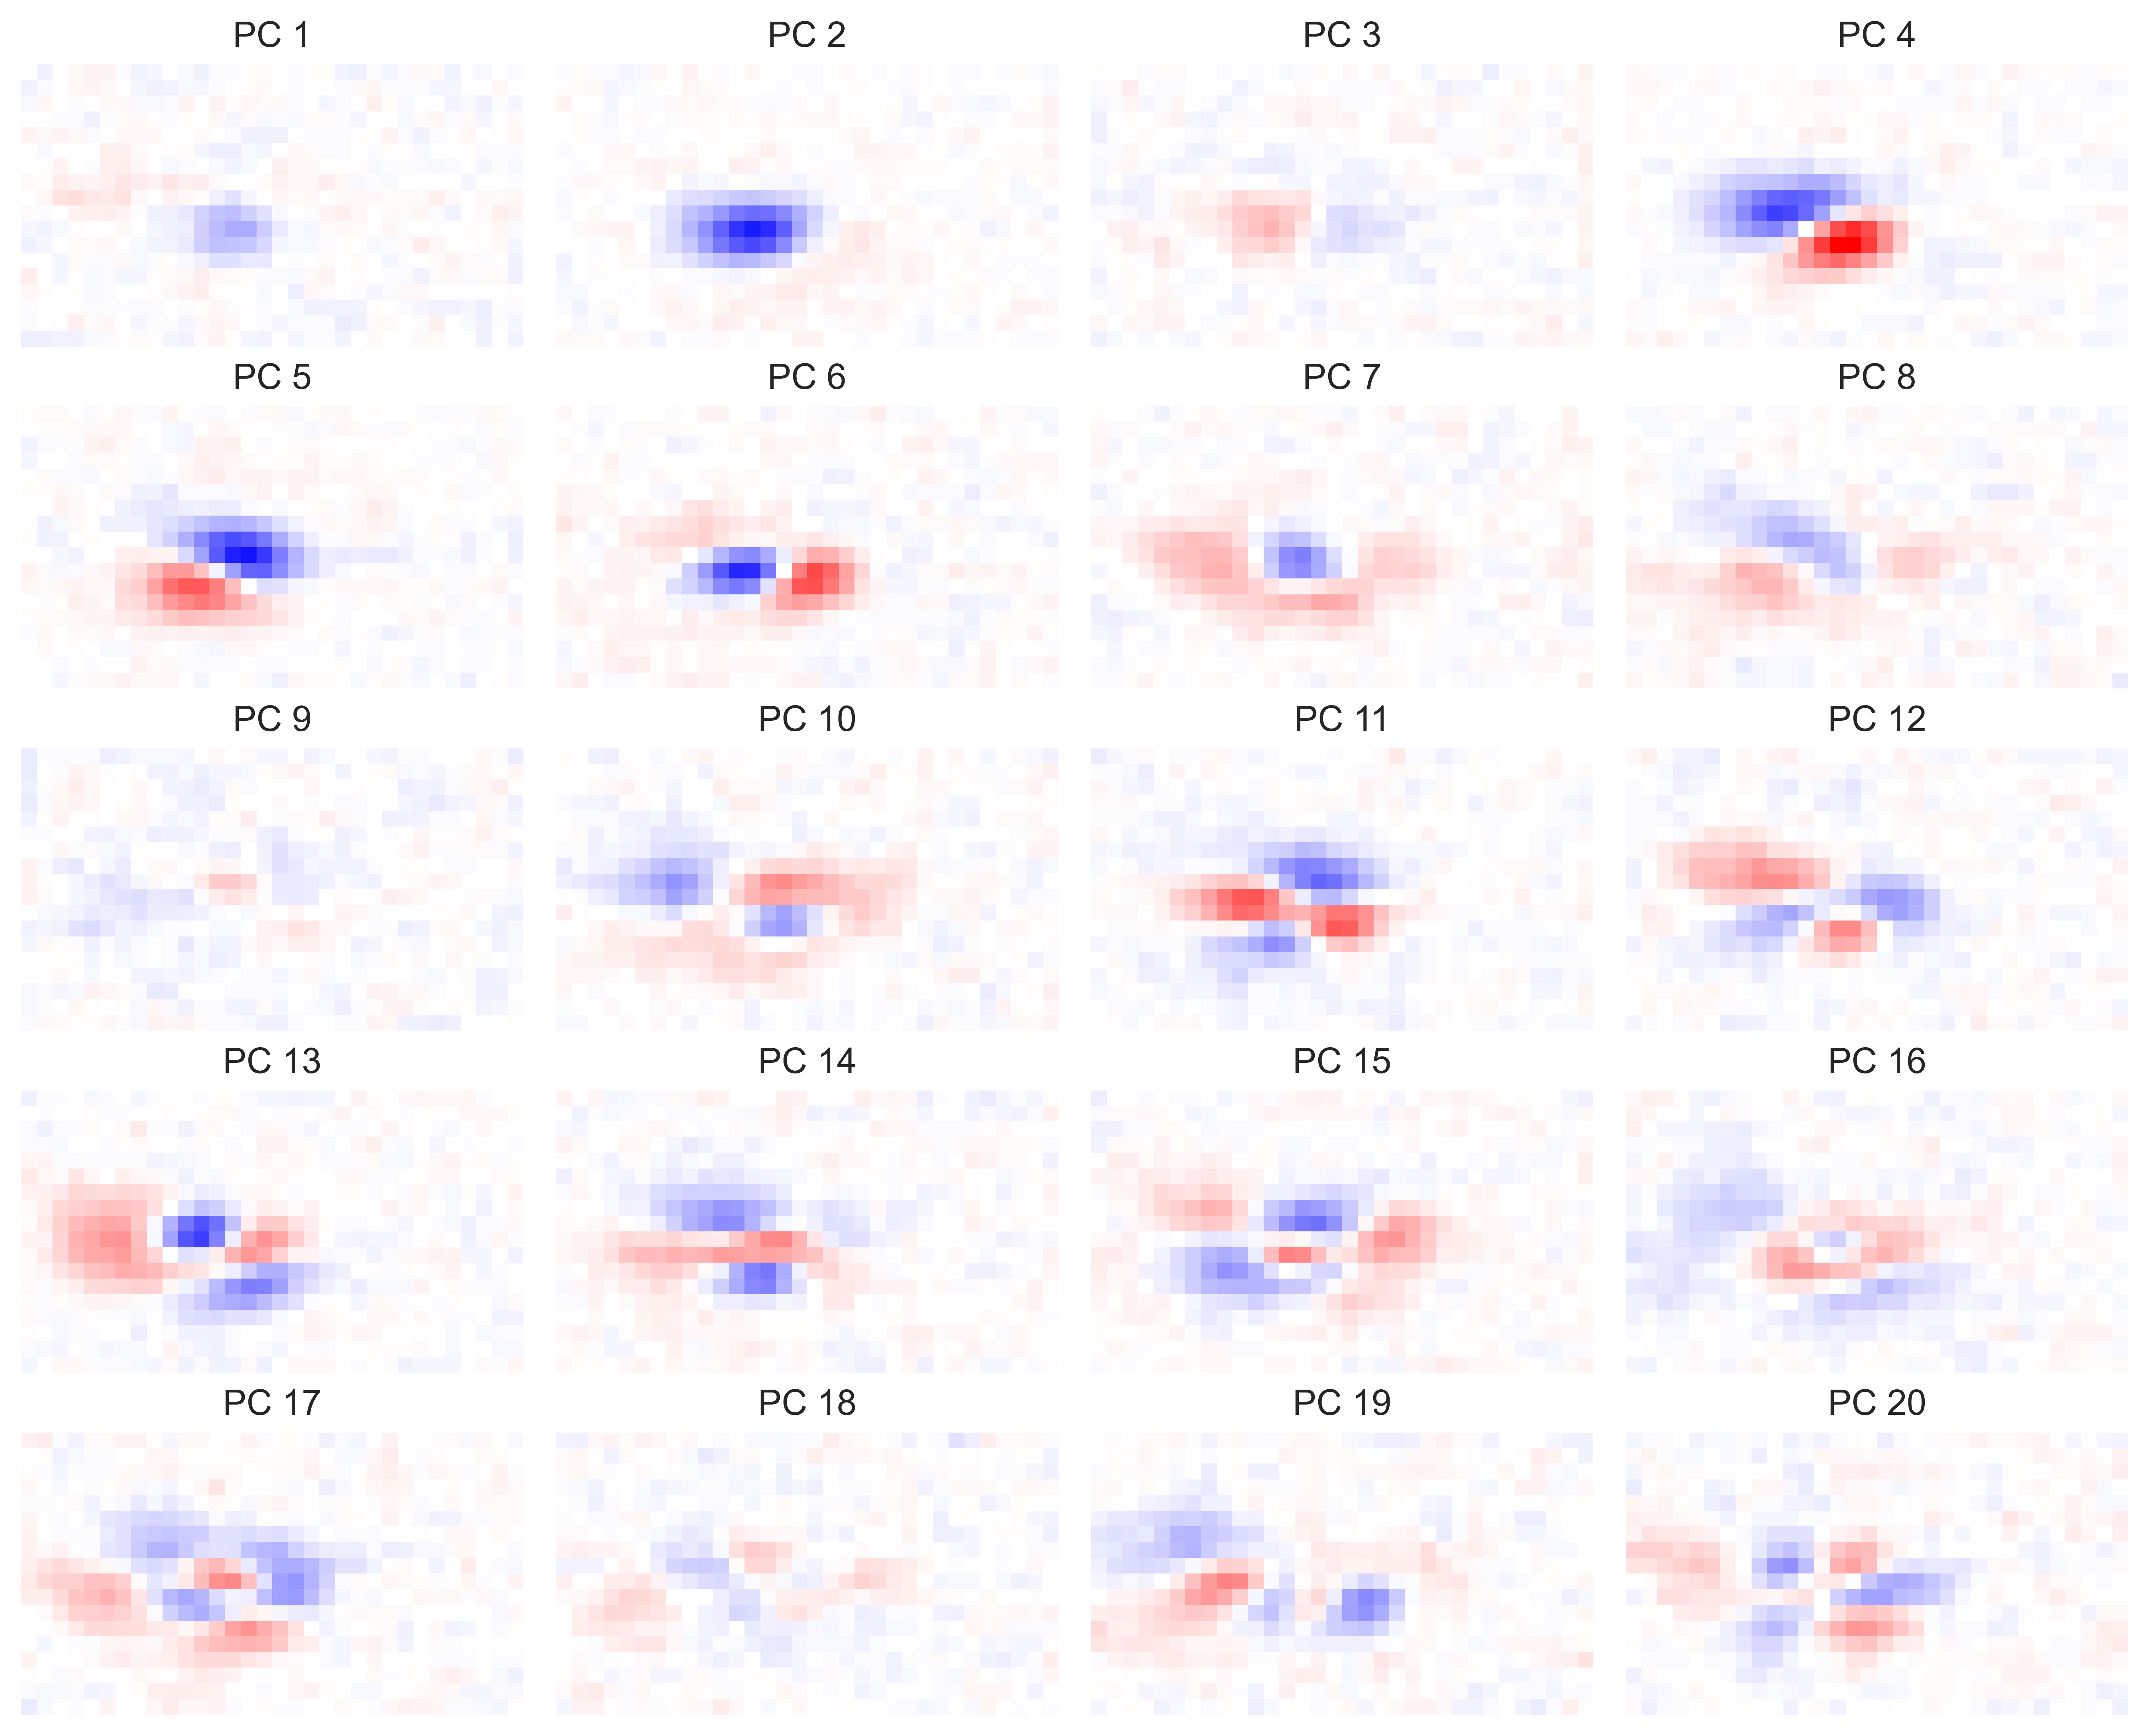

In [2]:
rf = ReceptiveField(loader, n_pcs=50, λ=1.1)
B = rf.fit(rf.loader.X, rf.loader.S)
rf.plot_rf(B)

### Generate RFs for every neuron.

In [3]:
rf = ReceptiveField(loader, n_pcs=0, λ=1.1)
B = rf.fit(rf.loader.X, rf.loader.S)

Running linear regression with ridge coefficient  1.10.


# Fit Gabor Wavelets

### Verify Fit Performance
`GaborDiag` is `GaborFit` with additional comparison functions.

Running linear regression with ridge coefficient  1.10.
Running linear regression with ridge coefficient  1.10.
Fitting Gabor.
Step     0 Corr: -0.0417 t:   9.36s
Step   300 Corr:  0.5913 t:  26.86s
Step   600 Corr:  0.6065 t:  31.31s
Step   900 Corr:  0.6134 t:  35.75s
Step  1200 Corr:  0.6176 t:  40.19s


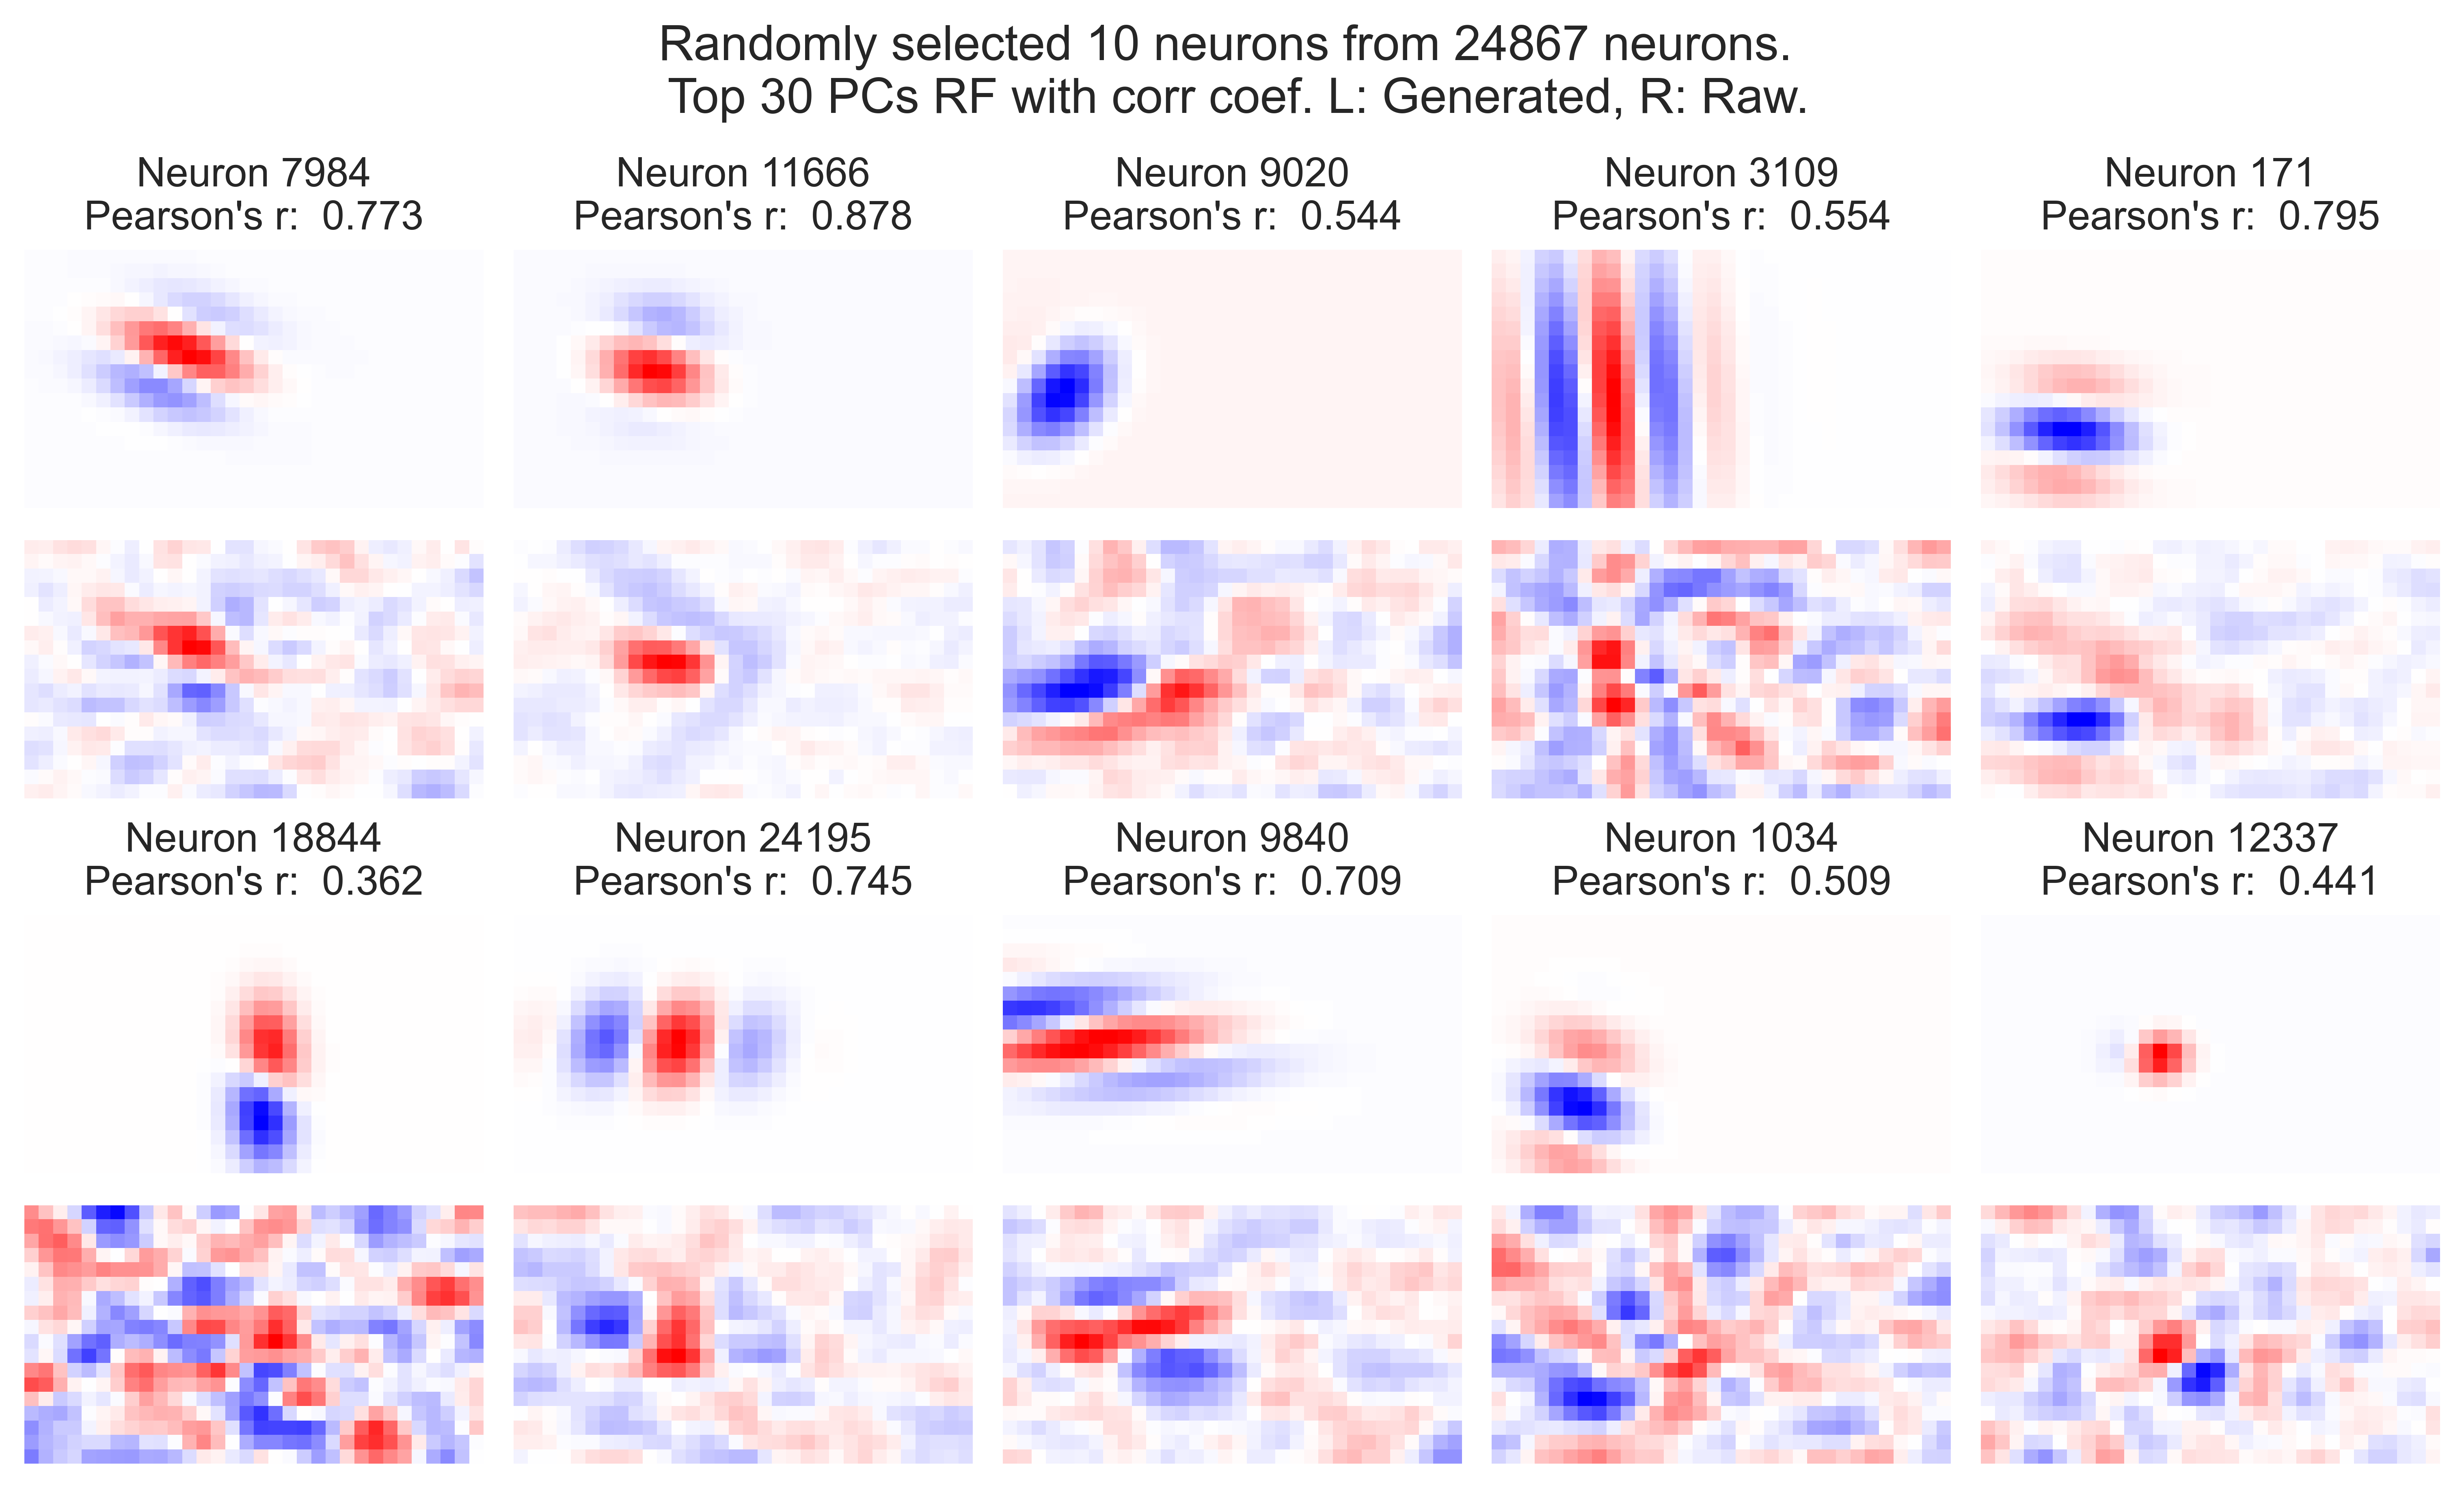

In [4]:
trX, teX, trS, teS = loader.train_test_split()
rf_tr = ReceptiveField(loader, n_pcs=0, λ=1.1)
rf_tr.fit(trX, trS)

rf_te = ReceptiveField(loader, n_pcs=0, λ=1.1)
rf_te.fit(teX, teS)

g_train = GaborDiag().fit(rf_tr.rf_)
g_test = GaborDiag().pca_rf(rf_te.rf_)

g_train.plot()

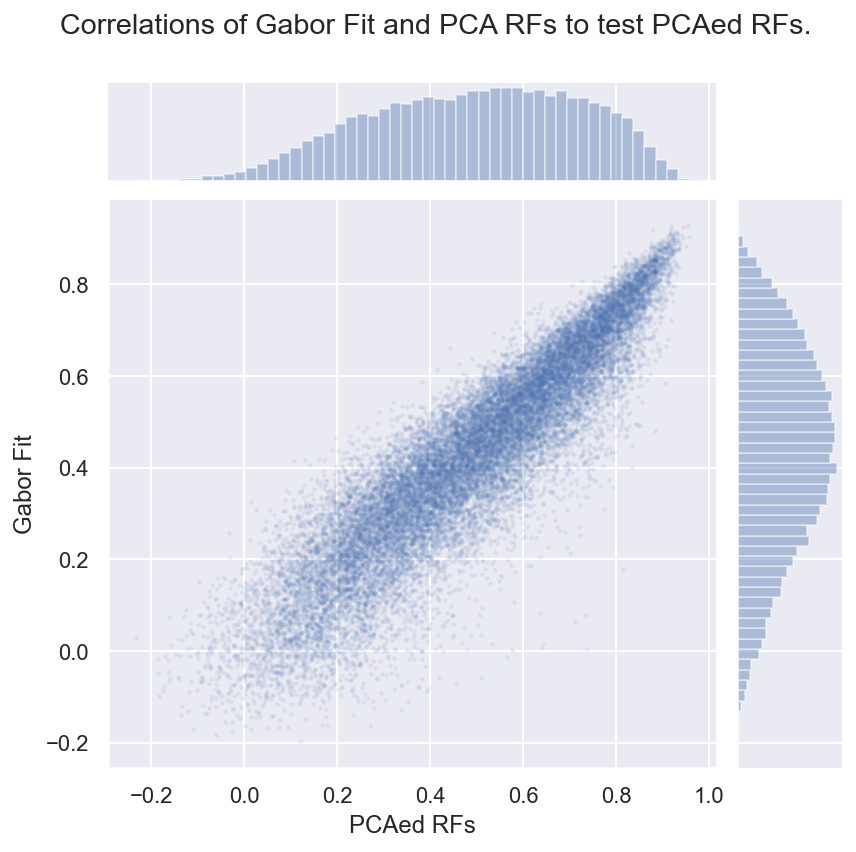

In [5]:
cor_pc = g_train.compare_pcaed_rf(g_test)['corr']
cor_fit = g_train.compare_fit(g_test)['corr']

df = pd.DataFrame([cor_pc, cor_fit]).T
df.columns = ['PCAed RFs', 'Gabor Fit']
g = sns.jointplot(data=df, x='PCAed RFs', y='Gabor Fit', kind='scatter', linewidth=0, s=5, alpha=0.1)
g.fig.suptitle('Correlations of Gabor Fit and PCA RFs to test PCAed RFs.')
plt.subplots_adjust(top=0.9)

Now that we have verified that the fit performance correlates well with differences in the train and test dataset, we fit the entire data

Fitting Gabor.
Step     0 Corr: -0.0482 t:   0.03s
Step   300 Corr:  0.6377 t:  17.23s
Step   600 Corr:  0.6527 t:  21.67s
Step   900 Corr:  0.6592 t:  26.11s
Step  1200 Corr:  0.6630 t:  30.56s
Step  1500 Corr:  0.6657 t:  35.00s
Step  1800 Corr:  0.6679 t:  39.44s
Step  2100 Corr:  0.6696 t:  43.88s
Step  2400 Corr:  0.6711 t:  48.33s
Step  2700 Corr:  0.6724 t:  52.77s


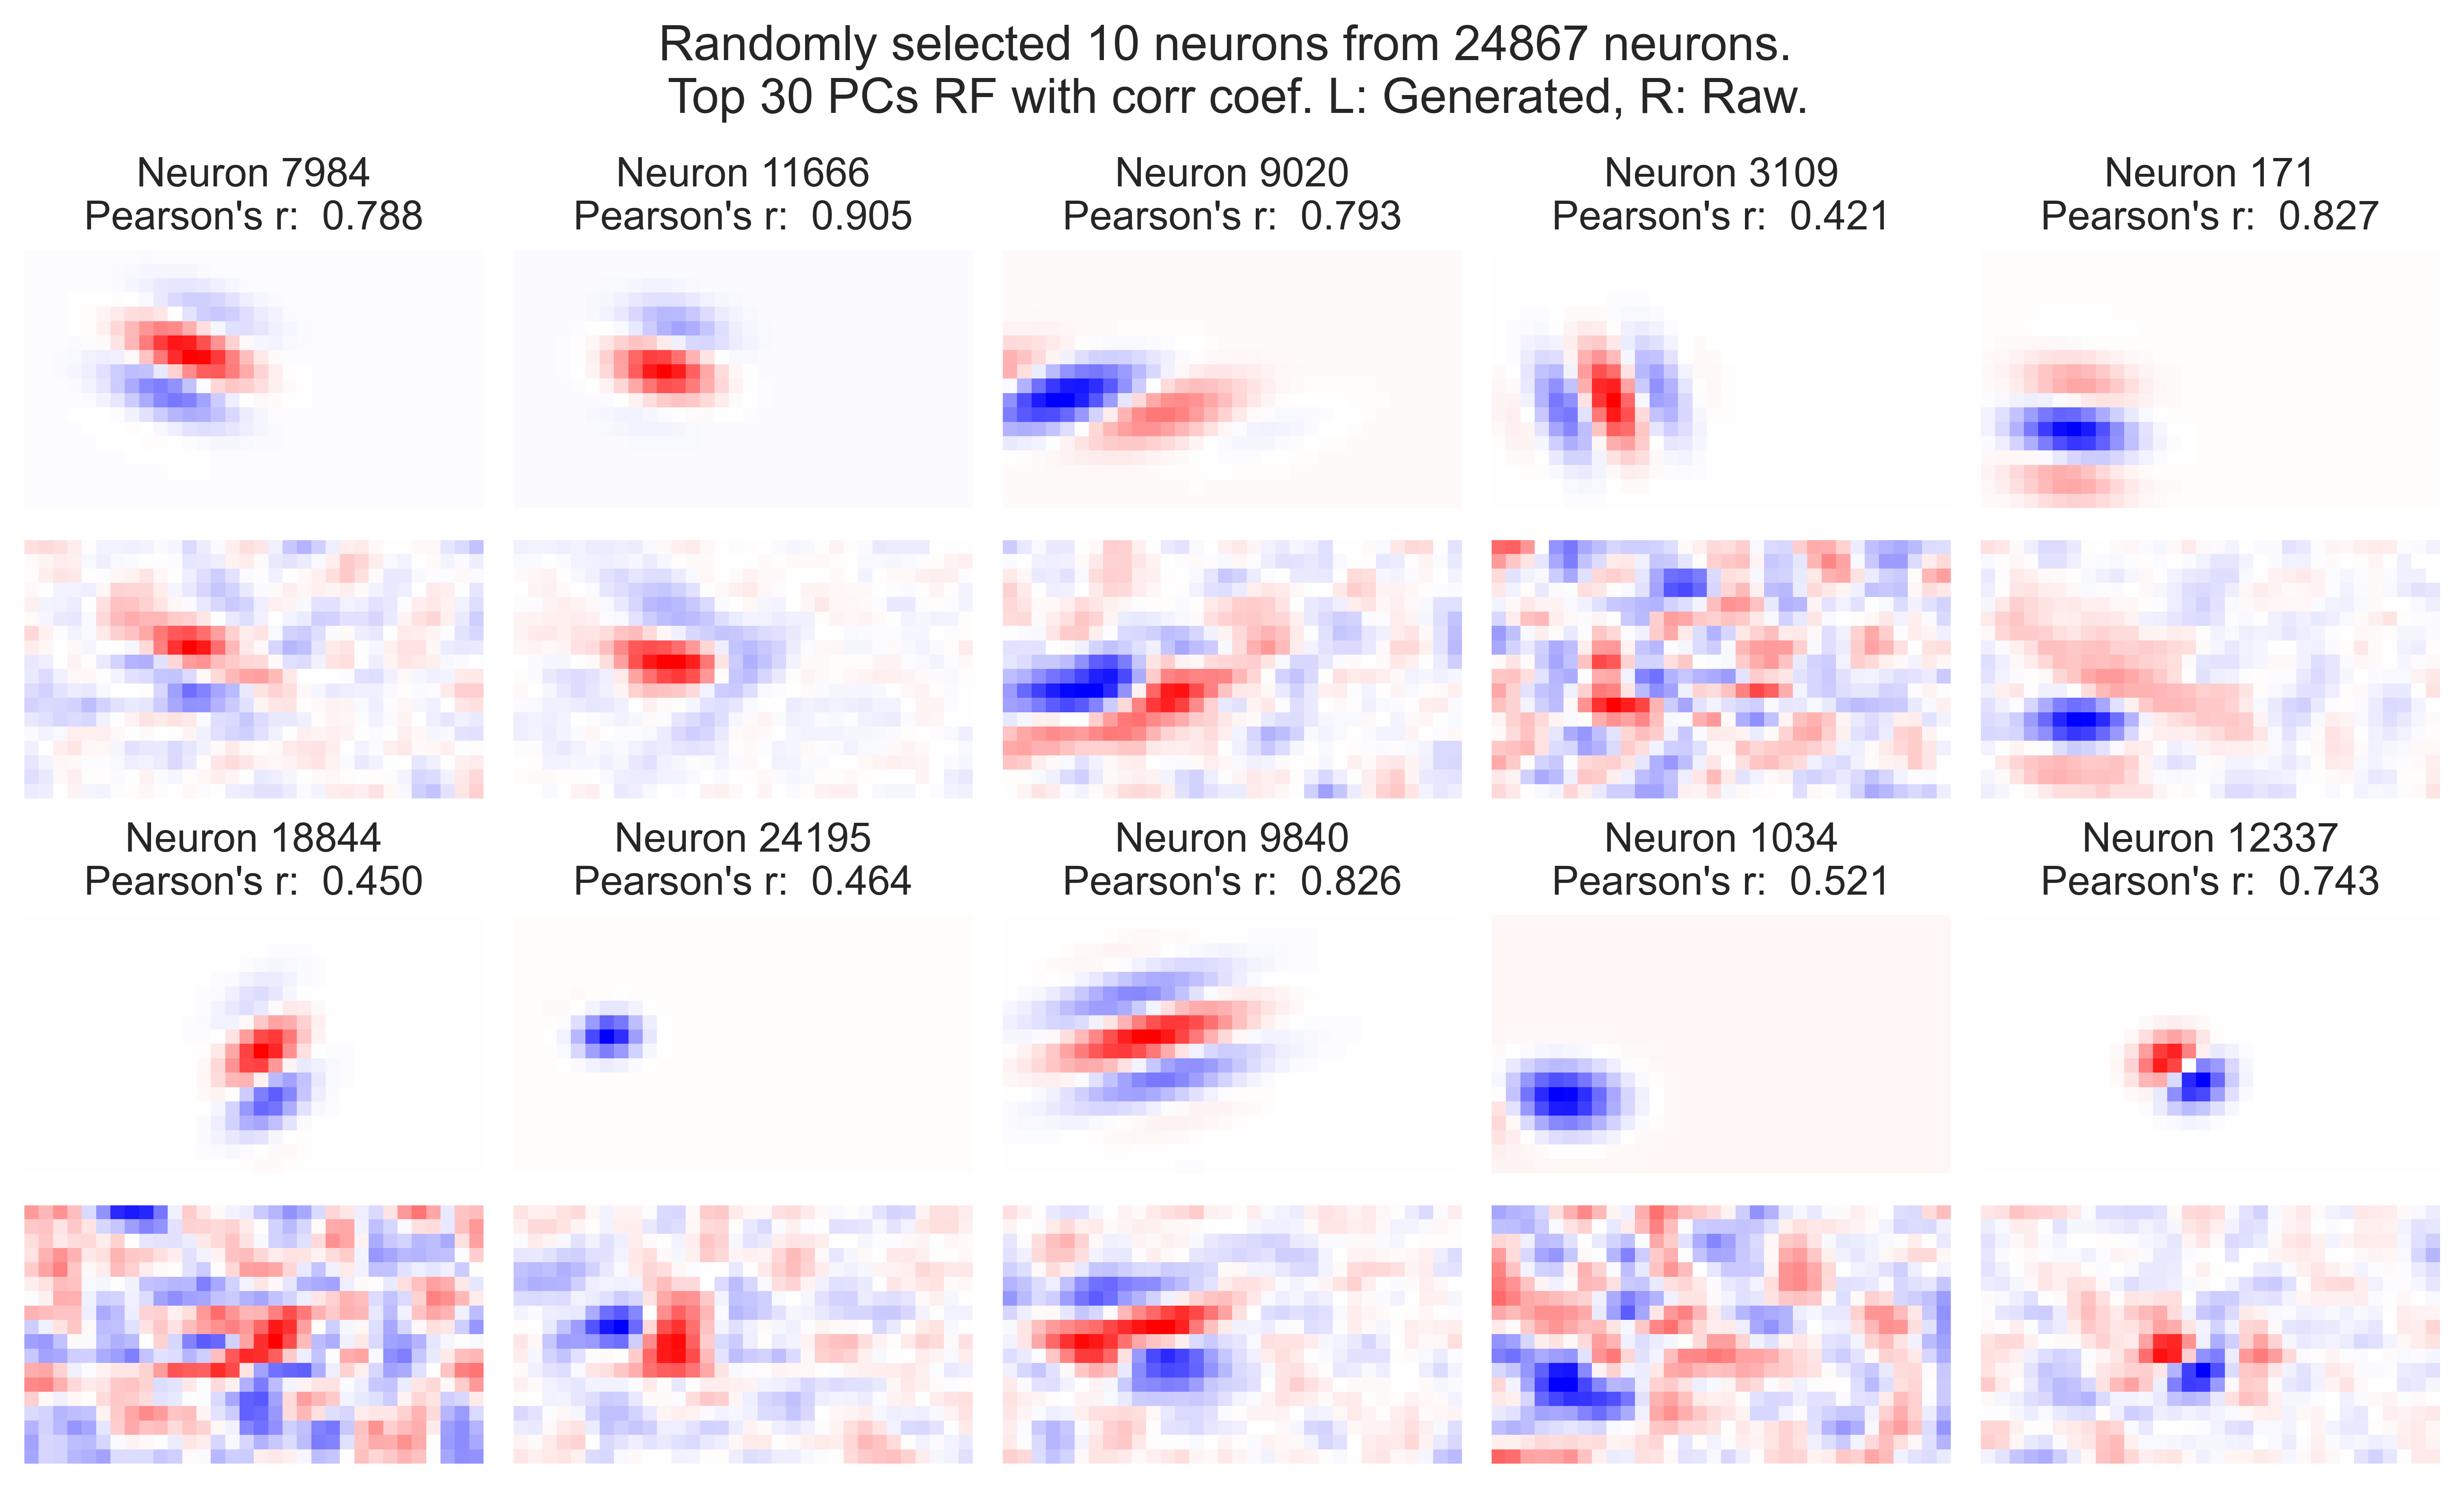

In [6]:
gabor = GaborFit(n_pc=30, n_iters=3000, rf_dim=(16, 9), optimizer=adam(1e-2)).fit(rf.rf_)
gabor.plot()

#### Distribution of Gabor parameters.

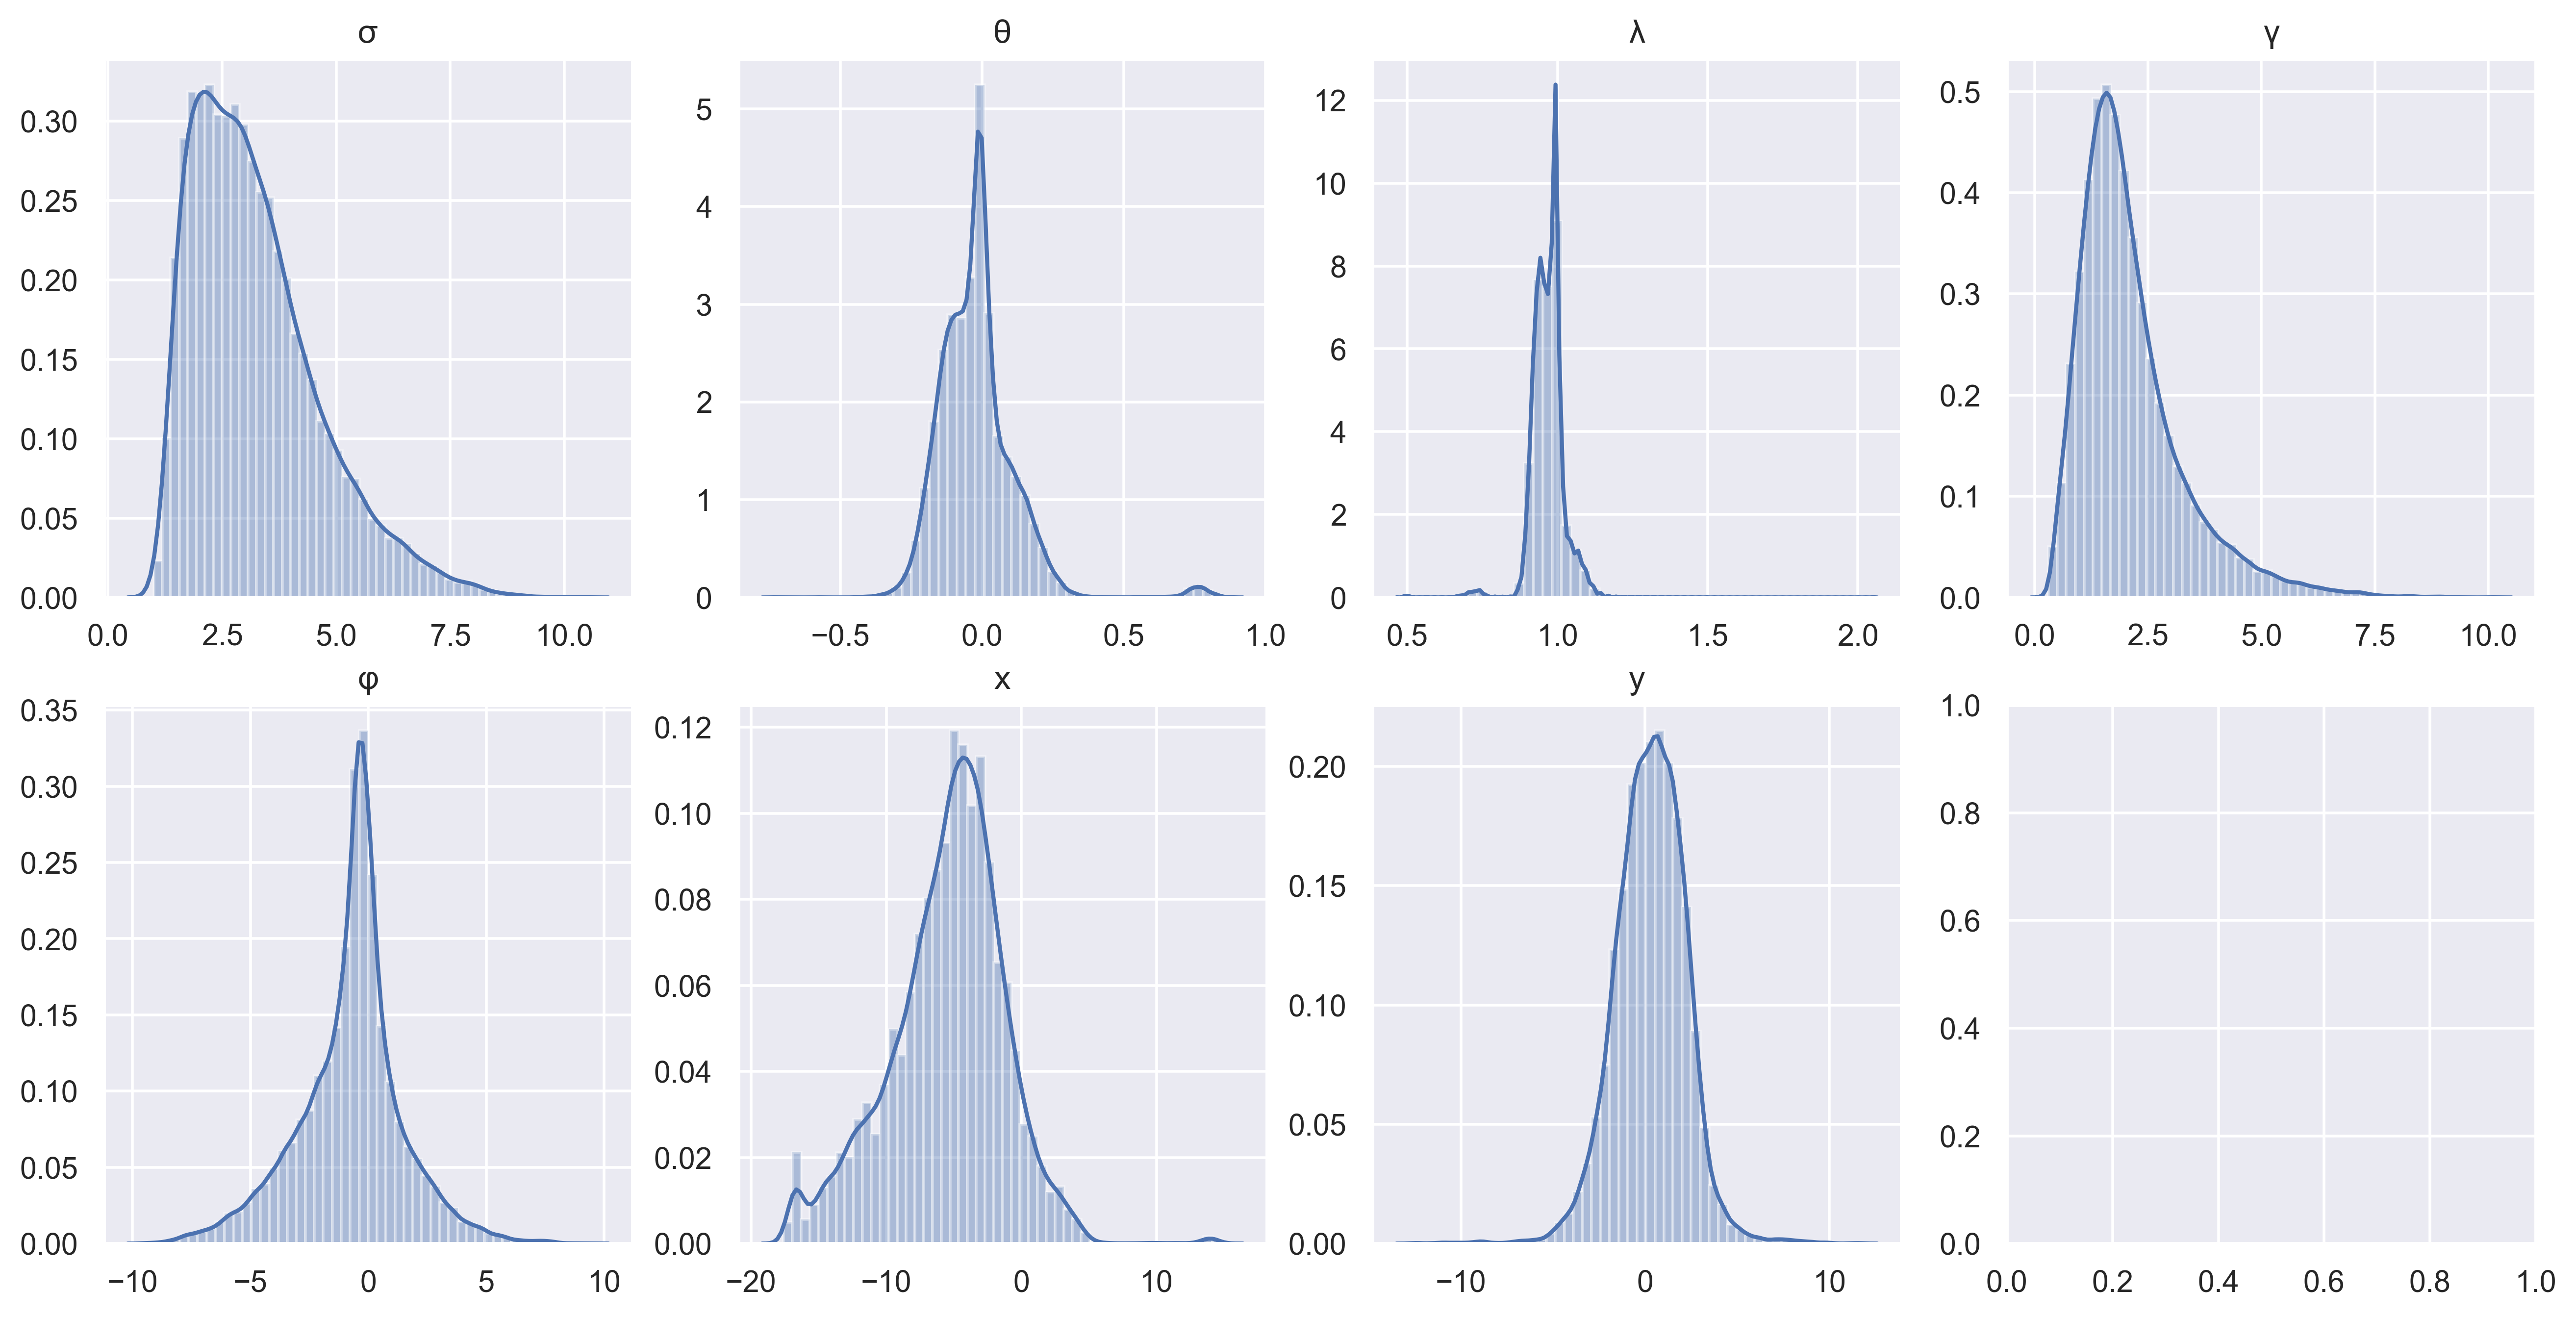

In [7]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16, 8), dpi=200)
axs = axs.flatten()
names = 'σθλγφxy'

for i in range(7):
    sns.distplot(gabor.params[:, i], ax=axs[i], label='work')
    axs[i].set_title(names[i])
plt.show()

## Retinotropy

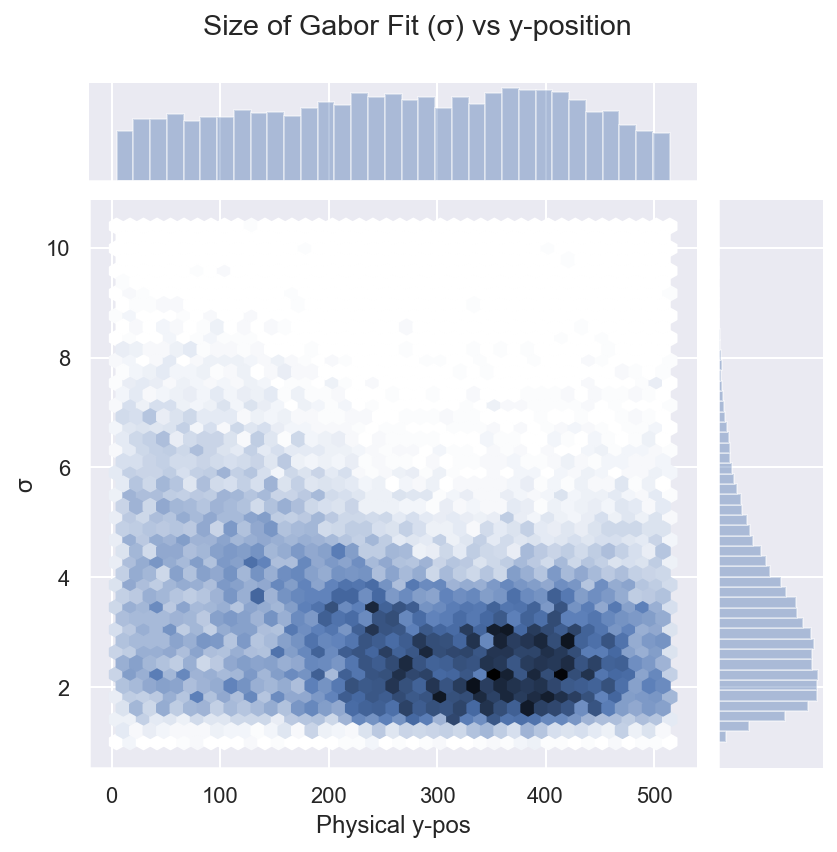

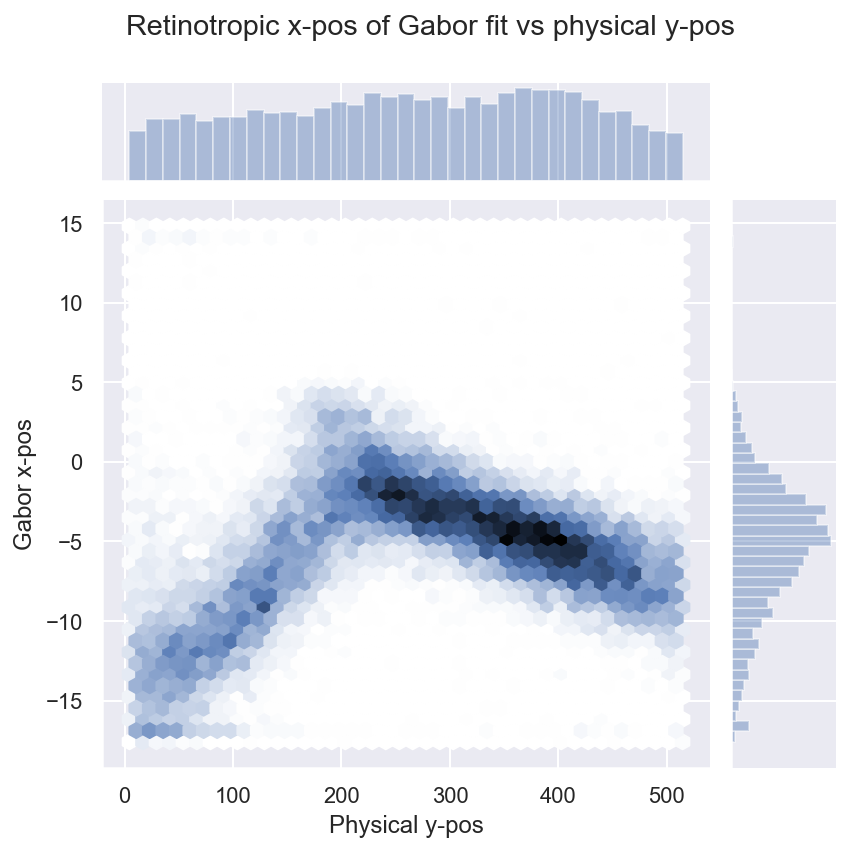

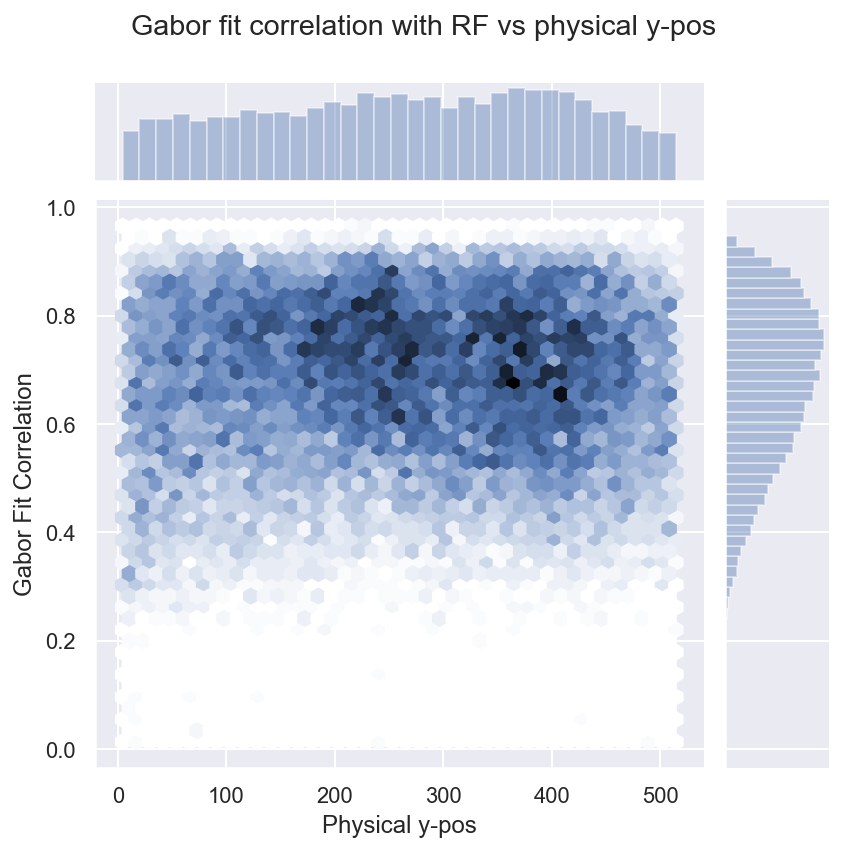

In [8]:
def make_hexplot(var, name, title):
    df = pd.DataFrame([loader.ypos, var]).T
    df.columns = ['Physical y-pos', name]
    g = sns.jointplot(data=df, x=df.columns[0], y=df.columns[1], kind='hex')
    g.fig.suptitle(title)
    plt.subplots_adjust(top=0.9)
    plt.show()

make_hexplot(gabor.params[:, 0], 'σ', 'Size of Gabor Fit (σ) vs y-position')
make_hexplot(gabor.params[:, -2], 'Gabor x-pos', 'Retinotropic x-pos of Gabor fit vs physical y-pos')
make_hexplot(gabor.corr, 'Gabor Fit Correlation', 'Gabor fit correlation with RF vs physical y-pos')